In [9]:
%matplotlib notebook
import datetime as dt  # Python standard library datetime  module
import numpy as np
import netCDF4  # http://code.google.com/p/netcdf4-python/
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, addcyclic, shiftgrid

import s2_py as s2
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, mapping

import os
import pickle
import wget
import subprocess


import matplotlib.animation as animation

import google.cloud.bigquery
import pandas_gbq
import pandas as pd
import shapefile as shp
import descartes
from shapely.geometry import Polygon, mapping, Point
from sklearn.metrics.pairwise import euclidean_distances

import itertools

<IPython.core.display.Javascript object>


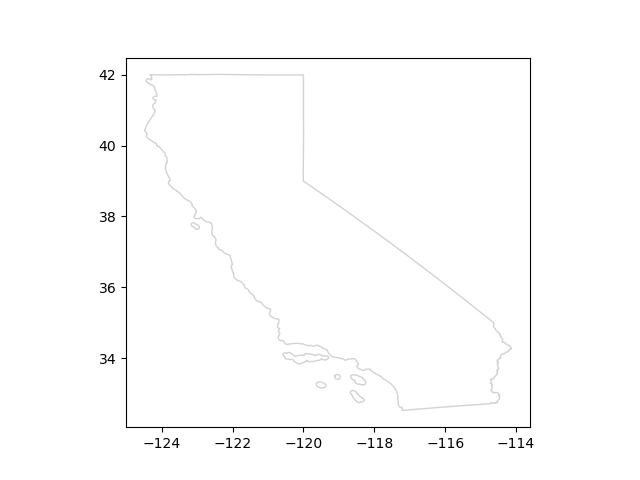

In [10]:
cal_shape_file = "/home/scott/w210_Wildfire/EDA/Data/CA_State/CA_State_TIGER2016.shp"

ca_df = gpd.read_file(cal_shape_file)
crs = {'init': 'epsg:4326'}
ca_df = ca_df.to_crs(crs)
ca_df.plot(color='white', edgecolor='lightgrey')
 

In [11]:
ca_df = ca_df.to_crs({'init': 'epsg:4326'})
ca_df

REGION DIVISION STATEFP   STATENS GEOID STUSPS        NAME LSAD  MTFCC  \
0      4        9      06  01779778    06     CA  California   00  G4000   

  FUNCSTAT         ALAND       AWATER     INTPTLAT      INTPTLON  \
0        A  403501101370  20466718403  +37.1551773  -119.5434183   

                                            geometry  
0  (POLYGON ((-119.6347313537315 33.2654466936341...

In [12]:
def extract_max_polygon(fire_poly):
    """Return the largest polygon for each wildfire multipolygon"""
    fire_map = mapping(fire_poly)
    if 'coordinates' in fire_map:
        coords = fire_map['coordinates']
    elif 'features' in fire_map:
        coords = fire_map['features'][0]['geometry']['coordinates']
    
    max_poly = coords[0][0]
    for i in range(len(coords)):
        if len(coords[i][0]) > len(max_poly):
            max_poly = coords[i][0]
    return max_poly

def create_S2_loop(max_poly):
    """Converts Polygon into S2 Loop"""
    points = []
    for coord in tuple(reversed(max_poly)):
        long, lat = coord
        latlng = s2.S2LatLng.FromDegrees(lat, long)
        points.append(latlng.ToPoint())
    return s2.S2Loop(points)

def create_S2_coverer(loop, lvl):
    """Generates a list of S2 Cells of specified level"""
    coverer = s2.S2RegionCoverer()
    coverer.set_min_level(lvl)
    coverer.set_max_level(lvl)
    return coverer.GetCovering(loop)

In [13]:
# Now we can extract only the largest polygon to build S2 Cells.
ca_df['Largest_polygon'] = ca_df.geometry.apply(extract_max_polygon)
ca_df.head()

REGION DIVISION STATEFP   STATENS GEOID STUSPS        NAME LSAD  MTFCC  \
0      4        9      06  01779778    06     CA  California   00  G4000   

  FUNCSTAT         ALAND       AWATER     INTPTLAT      INTPTLON  \
0        A  403501101370  20466718403  +37.1551773  -119.5434183   

                                            geometry  \
0  (POLYGON ((-119.6347313537315 33.2654466936341...   

                                     Largest_polygon  
0  ((-124.13657496576488, 41.46445707660226), (-1...

In [14]:
# Now we can create an object called S2 loop based on that polygon's coordinates
ca_df['S2_Loop'] = ca_df.Largest_polygon.apply(create_S2_loop)
ca_df

REGION DIVISION STATEFP   STATENS GEOID STUSPS        NAME LSAD  MTFCC  \
0      4        9      06  01779778    06     CA  California   00  G4000   

  FUNCSTAT         ALAND       AWATER     INTPTLAT      INTPTLON  \
0        A  403501101370  20466718403  +37.1551773  -119.5434183   

                                            geometry  \
0  (POLYGON ((-119.6347313537315 33.2654466936341...   

                                     Largest_polygon  \
0  ((-124.13657496576488, 41.46445707660226), (-1...   

                                             S2_Loop  
0  <s2_py.pywraps2.S2Loop; proxy of <Swig Object ...

In [15]:
# Now let's generate all S2 cells of level 10 over the entire CA mainland
ca_df['S2_Cells'] = ca_df.S2_Loop.apply(create_S2_coverer, args=[10])
ca_df

REGION DIVISION STATEFP   STATENS GEOID STUSPS        NAME LSAD  MTFCC  \
0      4        9      06  01779778    06     CA  California   00  G4000   

  FUNCSTAT         ALAND       AWATER     INTPTLAT      INTPTLON  \
0        A  403501101370  20466718403  +37.1551773  -119.5434183   

                                            geometry  \
0  (POLYGON ((-119.6347313537315 33.2654466936341...   

                                     Largest_polygon  \
0  ((-124.13657496576488, 41.46445707660226), (-1...   

                                             S2_Loop  \
0  <s2_py.pywraps2.S2Loop; proxy of <Swig Object ...   

                                            S2_Cells  
0  (2/2212102122 , 2/2212102123 , 2/2212102200 , ...

In [16]:
def S2Cells_To_GPD(covering):
    geoms = []
    for cellid in covering:
        new_cell = s2.S2Cell(cellid)
        vertices = []
        for i in range(4):
            vertex = new_cell.GetVertex(i)
            latlng = s2.S2LatLng(vertex)
            vertices.append((latlng.lng().degrees(),
                             latlng.lat().degrees()))
        geo = Polygon(vertices)
        geoms.append(geo)
    return gpd.GeoDataFrame(crs={'init': 'epsg:4326'}, geometry=geoms) 

In [17]:
ca_s2_df = S2Cells_To_GPD(ca_df['S2_Cells'][0])
ca_s2_df.head()

geometry
0  POLYGON ((-121.4677316834114 42.04232965429553...
1  POLYGON ((-121.3727682209074 42.07118272583848...
2  POLYGON ((-121.1142610115251 42.07239958691621...
3  POLYGON ((-121.0461208729064 42.01617736891059...
4  POLYGON ((-121.1410057347761 41.98772206109075...

<IPython.core.display.Javascript object>


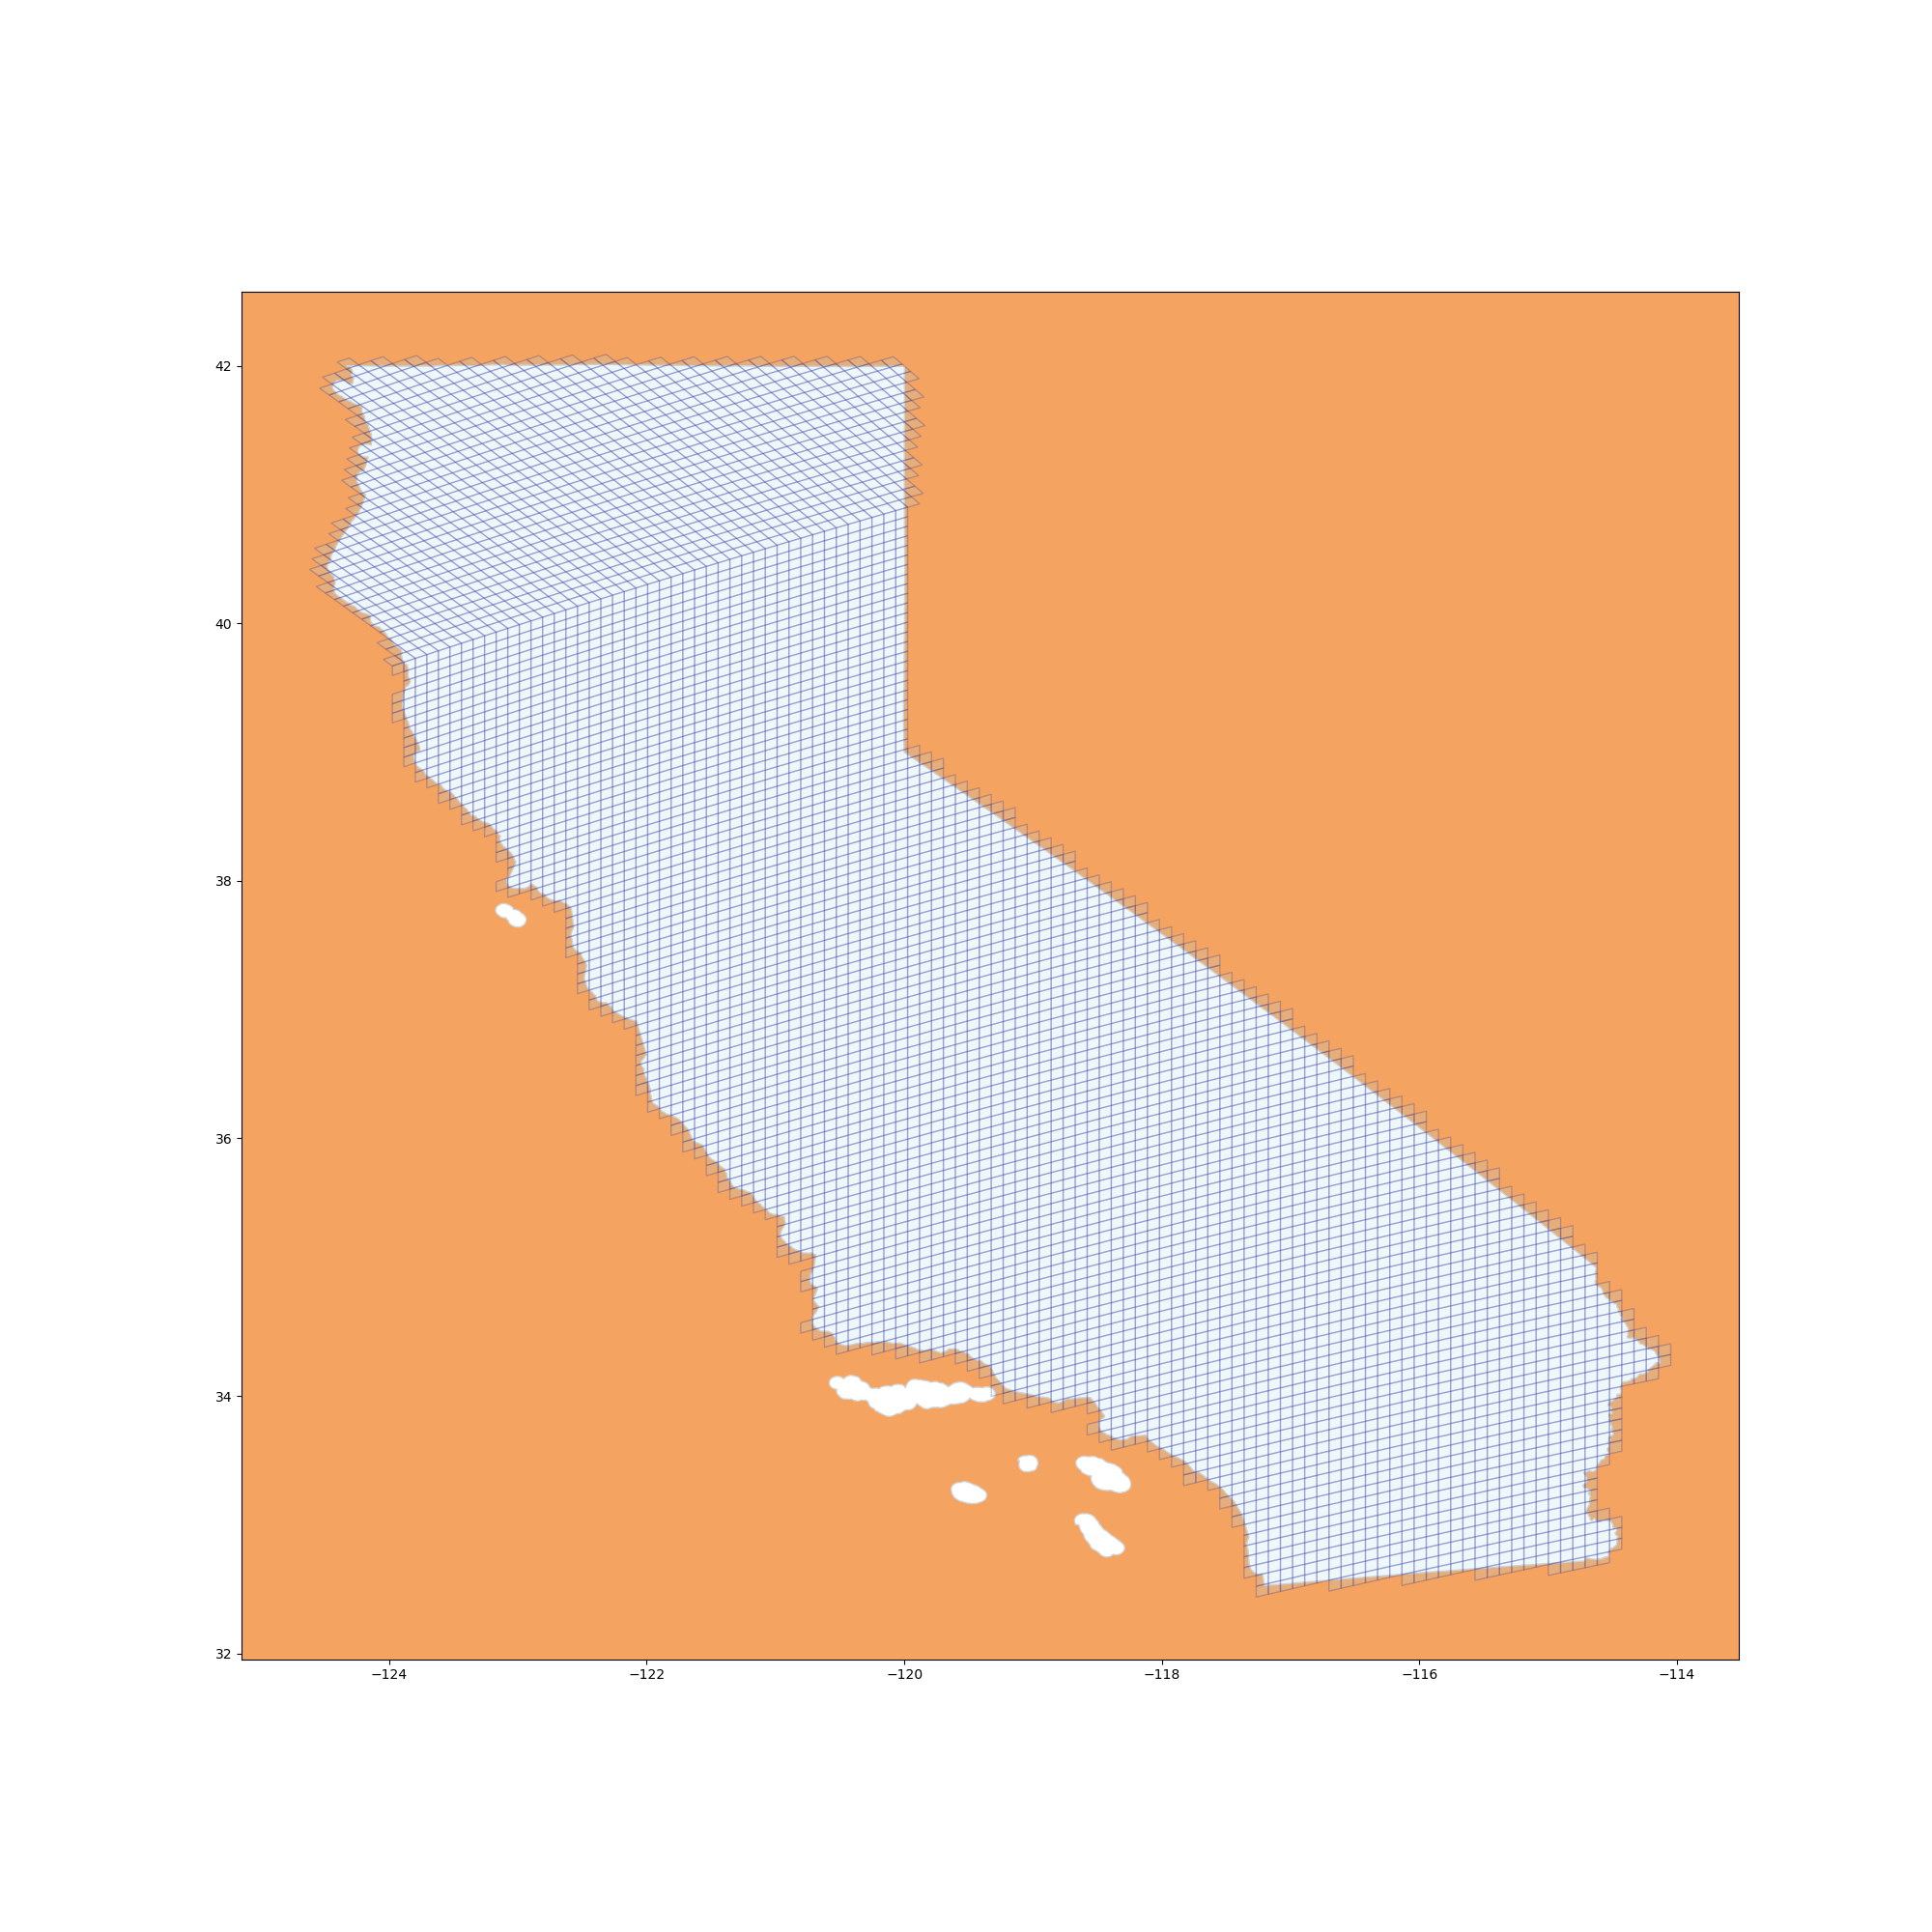

In [18]:
fig, ax = plt.subplots(figsize=(20,20))
ax.set_aspect('equal')
ax.set_facecolor('sandybrown')
ca_df.plot(ax=ax, color='white', edgecolor='lightgrey')
ca_s2_df.plot(ax=ax, color='lightblue', edgecolor='darkblue', alpha=0.2)
plt.show()

<IPython.core.display.Javascript object>


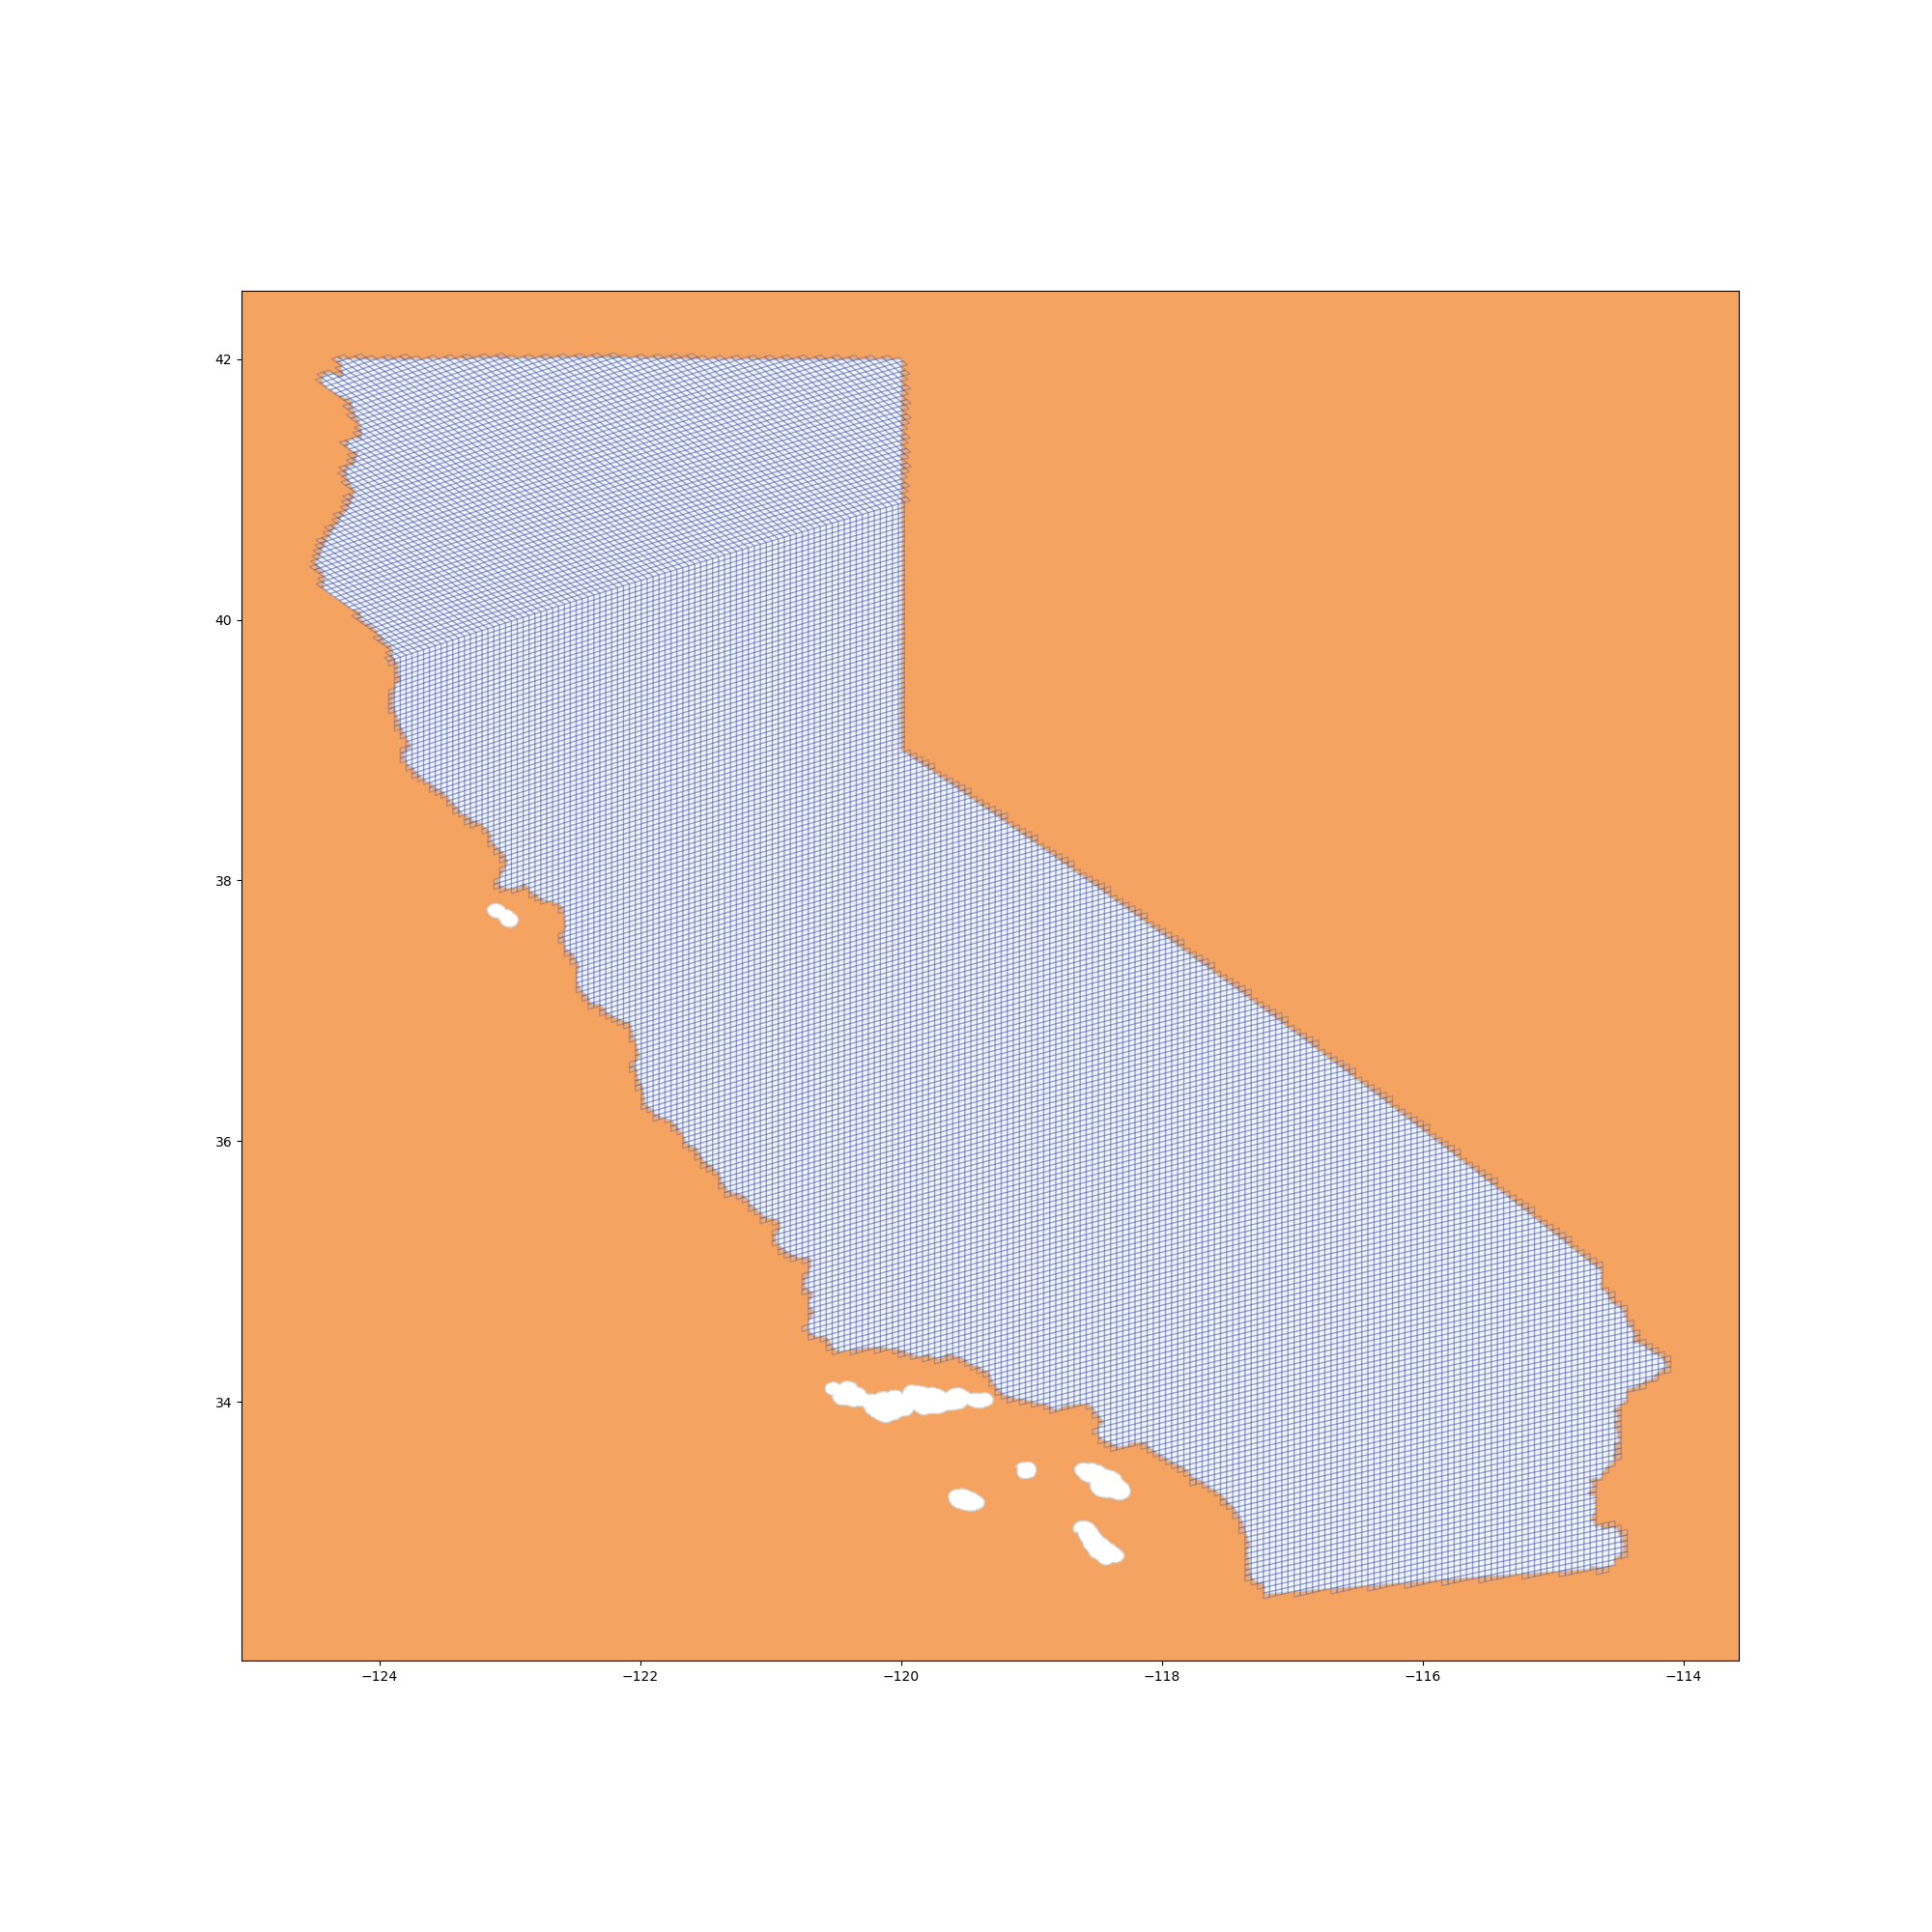

In [63]:
# Now let's generate all S2 cells of level 11 over the entire CA mainland
ca_df['S2_Cells'] = ca_df.S2_Loop.apply(create_S2_coverer, args=[11])
ca_df

ca_s2_df = S2Cells_To_GPD(ca_df['S2_Cells'][0])
ca_s2_df.head()

fig, ax = plt.subplots(figsize=(20,20))
ax.set_aspect('equal')
ax.set_facecolor('sandybrown')
ca_df.plot(ax=ax, color='white', edgecolor='lightgrey')
ca_s2_df.plot(ax=ax, color='lightblue', edgecolor='darkblue', alpha=0.2)
plt.show()

<IPython.core.display.Javascript object>


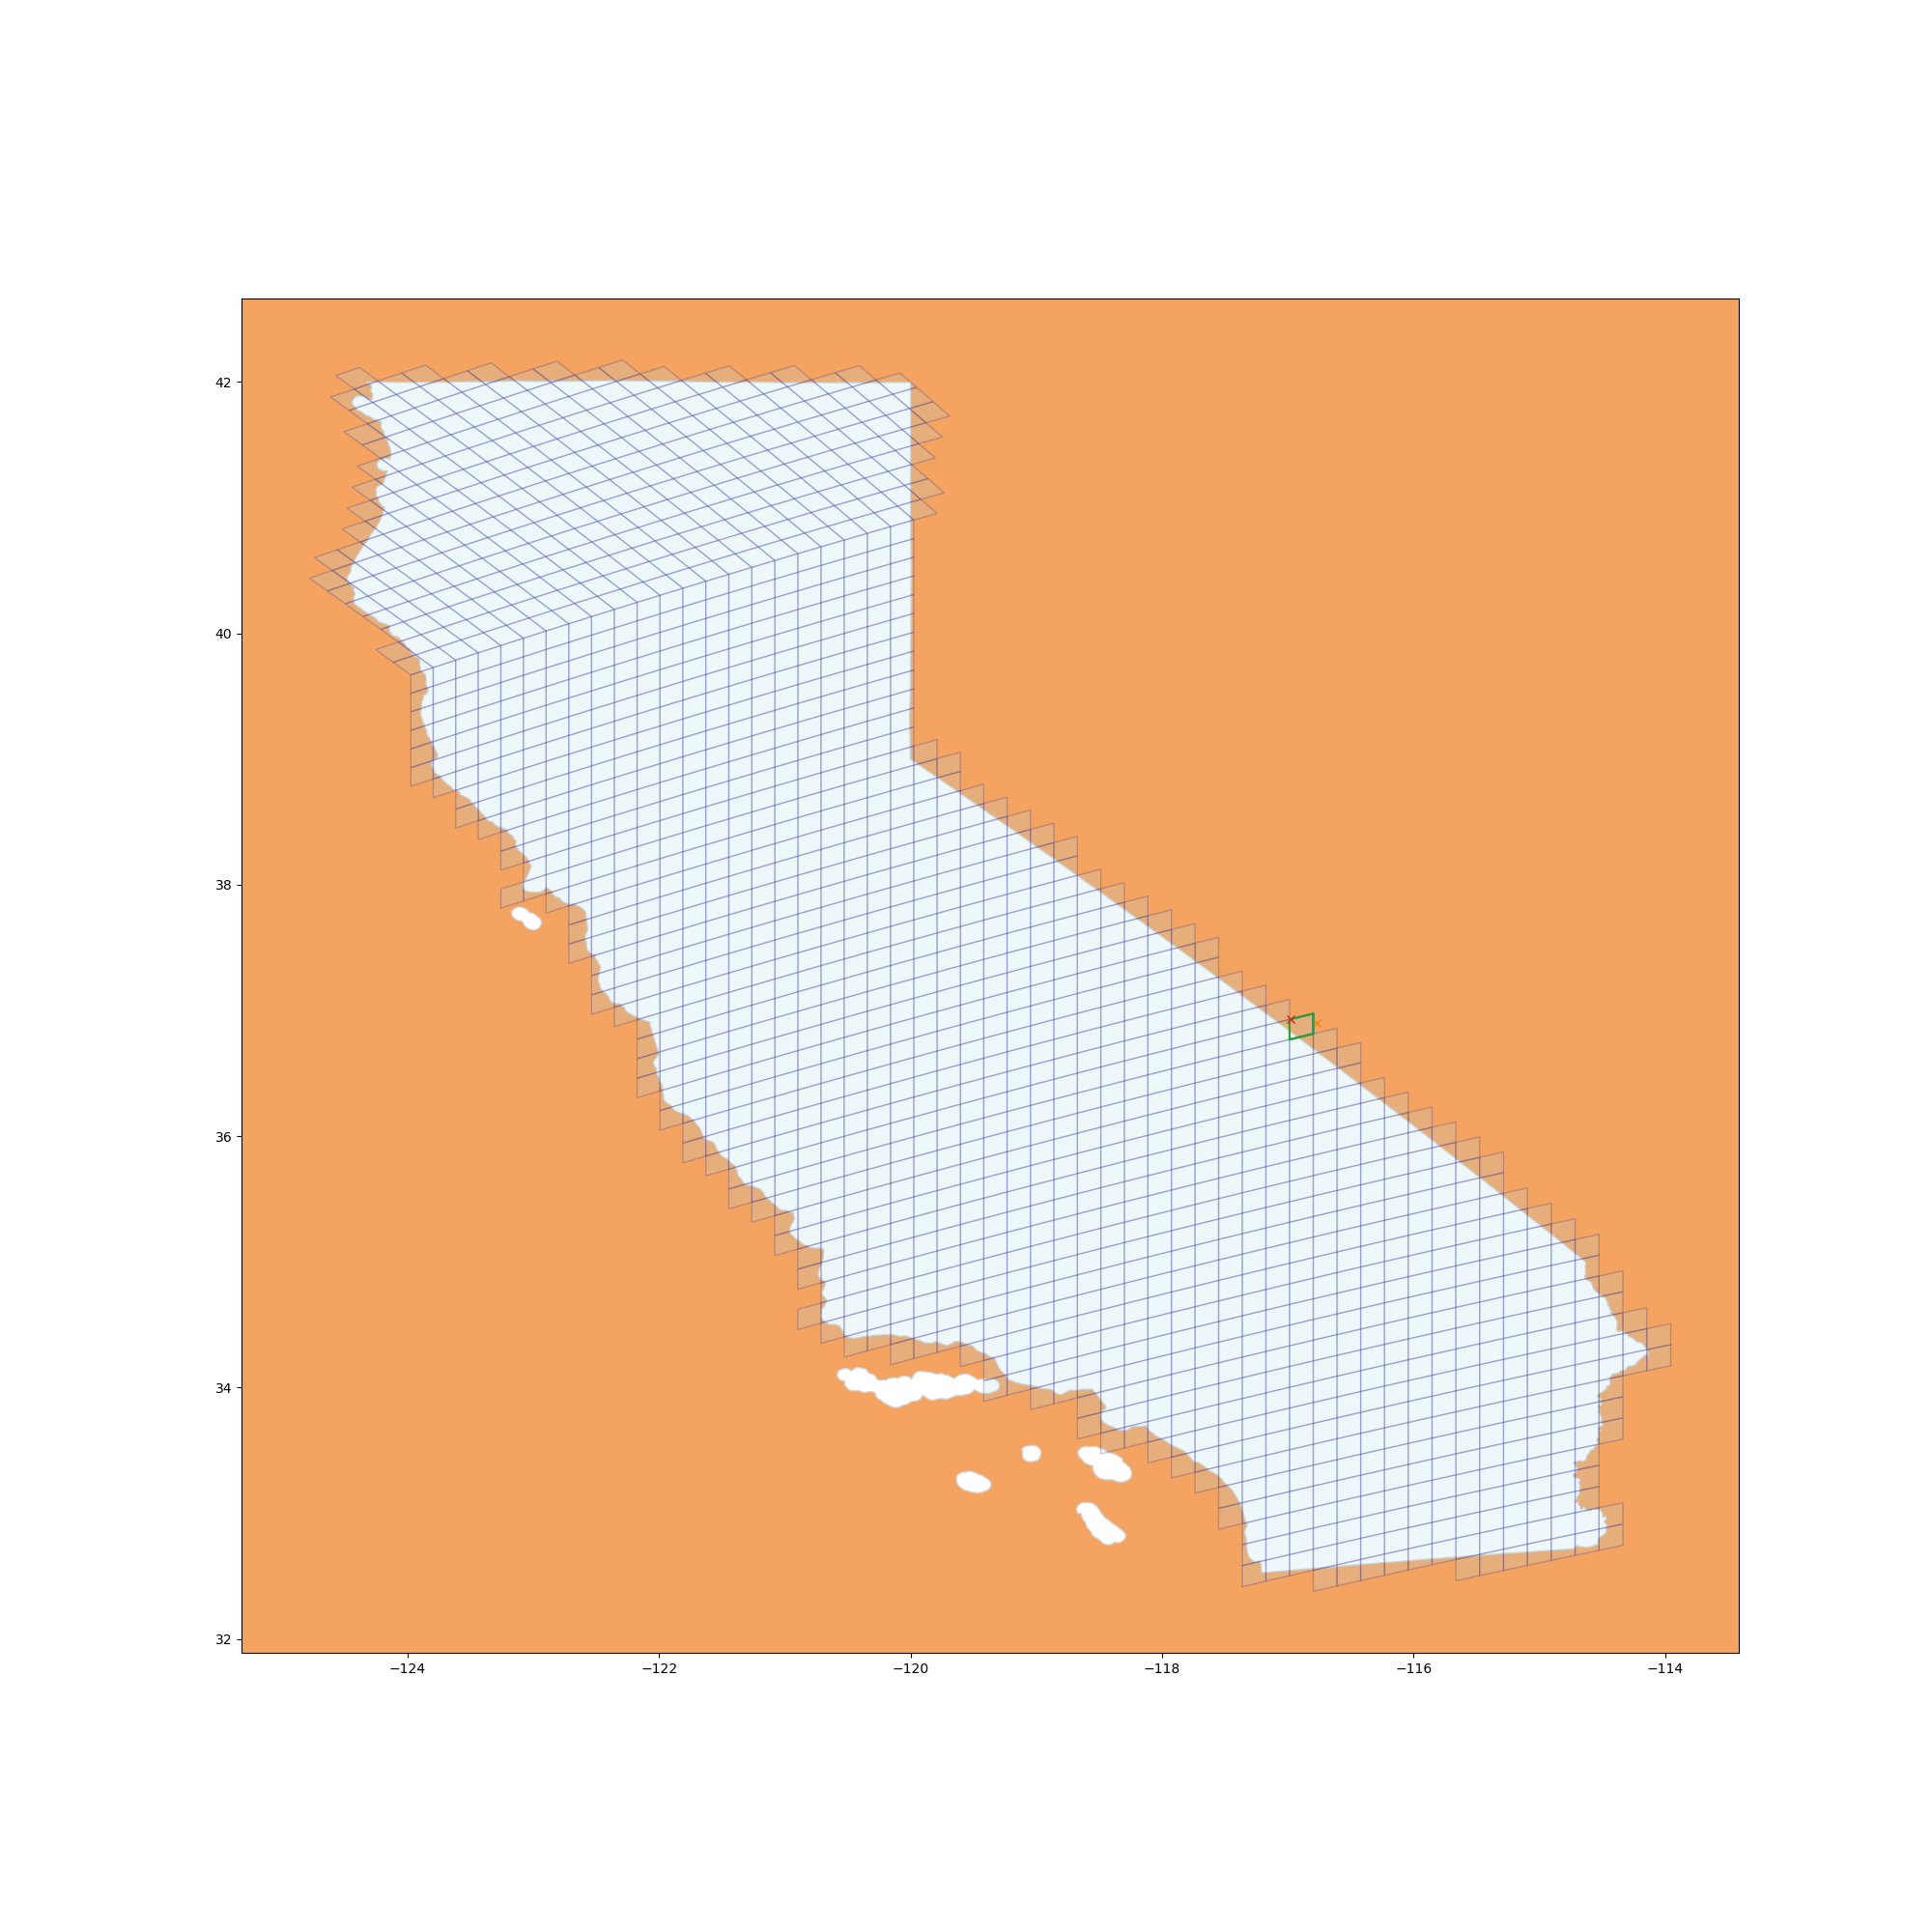

In [19]:
# Now let's generate all S2 cells of level 9 over the entire CA mainland
ca_df['S2_Cells'] = ca_df.S2_Loop.apply(create_S2_coverer, args=[9])
ca_df

ca_s2_df = S2Cells_To_GPD(ca_df['S2_Cells'][0])
ca_s2_df.head()

fig, ax = plt.subplots(figsize=(20,20))
ax.set_aspect('equal')
ax.set_facecolor('sandybrown')
ca_df.plot(ax=ax, color='white', edgecolor='lightgrey')
ca_s2_df.plot(ax=ax, color='lightblue', edgecolor='darkblue', alpha=0.2)
plt.show()

In [20]:
os.getcwd()

'/home/scott/w210_Wildfire/sat_process'

In [21]:
# Courtesy Yulia
ca_s2_df = gpd.read_file("/home/scott/w210_Wildfire/DataPrep/Data/Processed/CA_S2Cells/CA_S2Cells.shp")

In [22]:
ca_s2_df.head()

CWA                        NAME STATE_ZONE FE_AREA      AREA  WF_cum_are  \
0  VEF  Death Valley National Park      CA227      ee  2.001602   37.487592   
1  VEF  Death Valley National Park      CA227      ee  2.001602   37.487592   
2  VEF  Death Valley National Park      CA227      ee  2.001602   37.487592   
3  VEF  Death Valley National Park      CA227      ee  2.001602   37.487592   
4  VEF  Death Valley National Park      CA227      ee  2.001602   37.487592   

  FZ_grp S2_Cells_I                                           geometry  
0    low     80b8a4  POLYGON ((-116.9852421934208 36.92851788893871...  
1    low     80b8ac  POLYGON ((-117.1735315927328 36.88229296981148...  
2    low     80b8b4  POLYGON ((-117.1735315927328 37.04169221702246...  
3    low     80be44  POLYGON ((-118.2994349957241 37.38986432048104...  
4    low     80be4c  POLYGON ((-118.2994349957241 37.23225420438236...

In [23]:
len(ca_s2_df)

10643

In [24]:
ca_s2_df.columns

Index(['CWA', 'NAME', 'STATE_ZONE', 'FE_AREA', 'AREA', 'WF_cum_are', 'FZ_grp',
       'S2_Cells_I', 'geometry'],
      dtype='object')

<IPython.core.display.Javascript object>


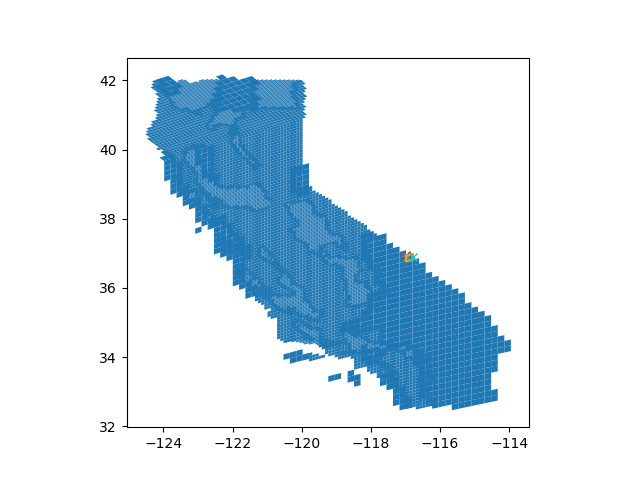

In [25]:
ca_s2_df['geometry'].plot()

### IMPORTANT note on FAPAR DATA

https://land.copernicus.eu/global/products/fapar
    
Projection and grid: 
The product is displayed in a regular latitude/longitude grid (plate carrée) with the ellipsoïd WGS 1984 (Terrestrial radius=6378km). The resolution of the grid is 1/336°. The reference is the centre of the pixel. It means that the longitude of the upper left corner of the pixel is (pixel_longitude – angular_resolution/2.)

We need a FAPAR value for each S2 cell.  At level 11 the S2 cell is bigger than the FAPAR pixel and we have to apply averaging.

I need some kind of area averaging.

Maybe it will help to plot the FAPAR data on top of the existing dataframe to get a sense?


In [26]:
ca_s2_df[['S2_Cells_I', 'geometry']].head()

S2_Cells_I                                           geometry
0     80b8a4  POLYGON ((-116.9852421934208 36.92851788893871...
1     80b8ac  POLYGON ((-117.1735315927328 36.88229296981148...
2     80b8b4  POLYGON ((-117.1735315927328 37.04169221702246...
3     80be44  POLYGON ((-118.2994349957241 37.38986432048104...
4     80be4c  POLYGON ((-118.2994349957241 37.23225420438236...

In [27]:
def pixelInCell(geometry, pixel):
    """
    Checks if a pixel, denoted by [lon, lat], 
    where [lon, lat] represent the pixel center, 
    is within a given s2cell 
    
    :param geometry:  A shapely geometry, representing an S2 cell
    :param pixel: A list, formatted as [lon, lat]
    :returns: Boolean indicating whether pixel is in the S2 cell.
    """
    lon = pixel[0]
    lat = pixel[1]
    pixCtr = Point(lon, lat)
    
    return(geometry.contains(pixCtr))

In [37]:
pixel = [-116.98 ,36.93]
pixelInCell(ca_s2_df['geometry'][0], pixel)

False

<IPython.core.display.Javascript object>


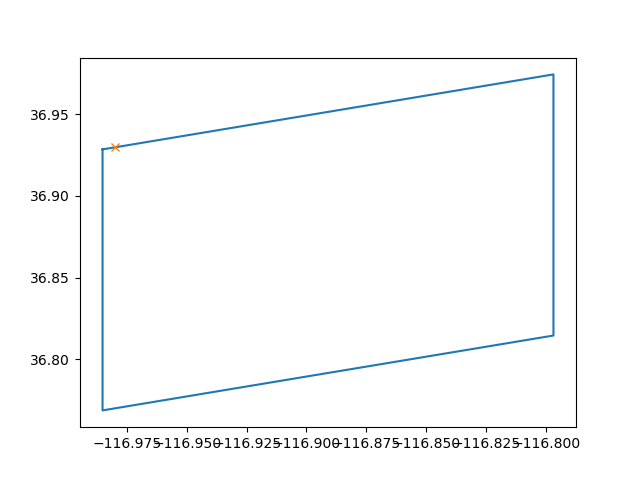

In [39]:
plt.figure()
plt.plot(*ca_s2_df['geometry'][0].exterior.xy)
plt.plot([pixel[0]], [pixel[1]], 'x')

<IPython.core.display.Javascript object>


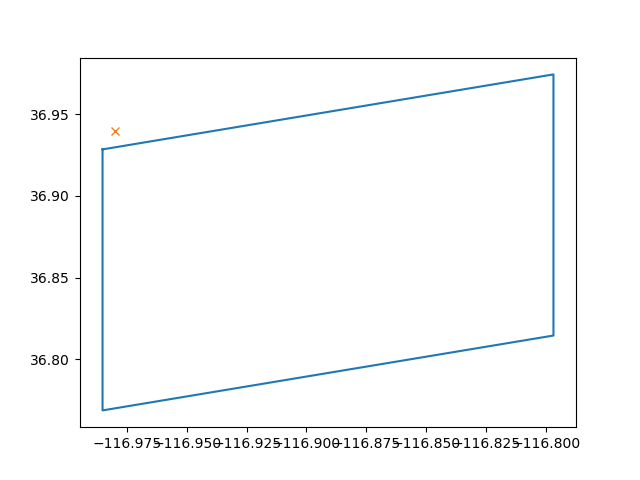

False

In [42]:
plt.figure()
pixel =[-116.98 ,36.94]
pixelInCell(ca_s2_df['geometry'][0], pixel)

<IPython.core.display.Javascript object>


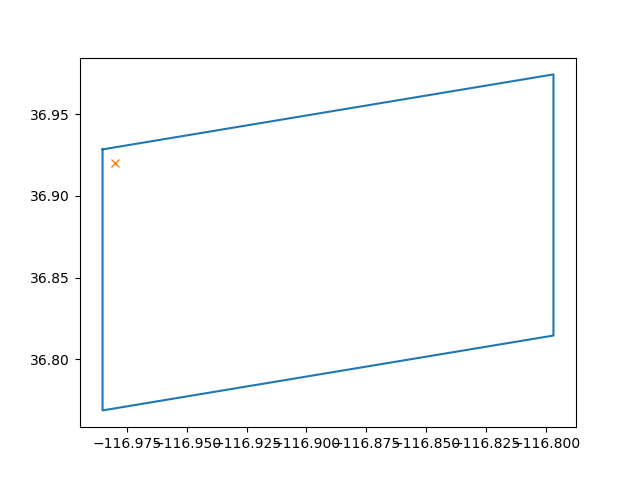

In [45]:
plt.figure()
plt.plot(*ca_s2_df['geometry'][0].exterior.xy)
plt.plot([pixel[0]], [pixel[1]], 'x')

In [46]:
pixel = [-116.98 ,36.92]
pixelInCell(ca_s2_df['geometry'][0], pixel)

True

<IPython.core.display.Javascript object>


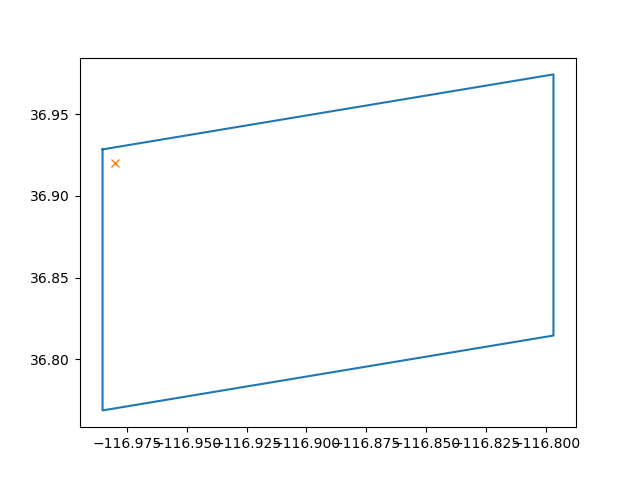

In [47]:
plt.figure()
plt.plot(*ca_s2_df['geometry'][0].exterior.xy)
plt.plot([pixel[0]], [pixel[1]], 'x')

True


<IPython.core.display.Javascript object>


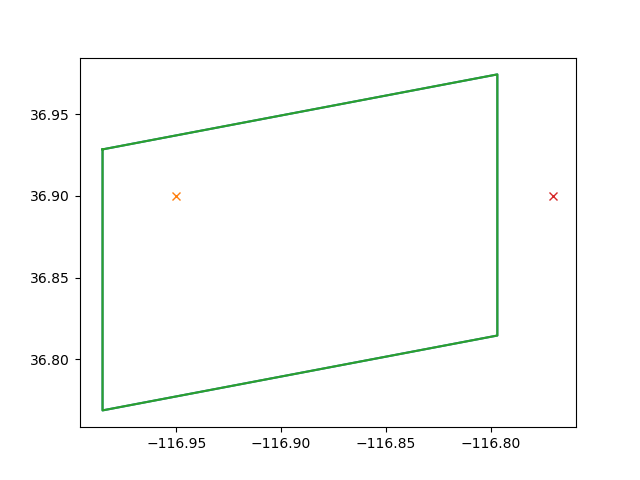

In [48]:
pixel = [-116.95, 36.9]
print(pixelInCell(ca_s2_df['geometry'][0], pixel))
plt.figure()
plt.plot(*ca_s2_df['geometry'][0].exterior.xy)
plt.plot([pixel[0]], [pixel[1]], 'x')

In [49]:
pixel = [-116.77 ,36.9]
print(pixelInCell(ca_s2_df['geometry'][0], pixel))
plt.plot(*ca_s2_df['geometry'][0].exterior.xy)
plt.plot([pixel[0]], [pixel[1]], 'x')

False


In [50]:
data_dir = '/home/scott/sat_pickles'
picklefiles = {}
for dirpath, dirnames, filenames in os.walk(data_dir):
    for filename in [f for f in filenames if f.endswith(".pkl")]:
        picklefiles[filename] = (os.path.join(dirpath, filename))

In [51]:
picklefiles.keys()

dict_keys(['Lon300_201411200000_Calif_PROBAV_V1.0.1.pkl', 'Lat300_201604100000_Calif_PROBAV_V1.0.1.pkl', 'FAPAR300_201711200000_Calif_PROBAV_V1.0.1.pkl', 'Lon300_201505310000_Calif_PROBAV_V1.0.1.pkl', 'FAPAR300_201406300000_Calif_PROBAV_V1.0.1.pkl', 'Lon300_201610310000_Calif_PROBAV_V1.0.1.pkl', 'Lon300_201402280000_Calif_PROBAV_V1.0.1.pkl', 'FAPAR300_201708100000_Calif_PROBAV_V1.0.1.pkl', 'Lat300_201703310000_Calif_PROBAV_V1.0.1.pkl', 'Lat300_201508200000_Calif_PROBAV_V1.0.1.pkl', 'FAPAR300_201406100000_Calif_PROBAV_V1.0.1.pkl', 'FAPAR300_201502280000_Calif_PROBAV_V1.0.1.pkl', 'Lon300_201704300000_Calif_PROBAV_V1.0.1.pkl', 'FAPAR300_201509300000_Calif_PROBAV_V1.0.1.pkl', 'Lon300_201409200000_Calif_PROBAV_V1.0.1.pkl', 'Lat300_201504100000_Calif_PROBAV_V1.0.1.pkl', 'FAPAR300_201601200000_Calif_PROBAV_V1.0.1.pkl', 'FAPAR300_201606200000_Calif_PROBAV_V1.0.1.pkl', 'Lon300_201412200000_Calif_PROBAV_V1.0.1.pkl', 'FAPAR300_201706100000_Calif_PROBAV_V1.0.1.pkl', 'FAPAR300_201502200000_Calif_PR

In [52]:
#years = range(2014, 2020)
year = str(2014)
#for year in years:

# Lat / lon aren't dependent on year so I really only need the first entry, but this should be quick anyway

lats ={}
for filename, fullpath in picklefiles.items():
    if filename.startswith('Lat'):
        dateStart = filename.find(str(year))
        date = filename[dateStart:dateStart+8]
        
        with open(fullpath, 'rb') as f:
            lat = pickle.load(f)
        lats[date] = lat

lons ={}
for filename, fullpath in picklefiles.items():
    if filename.startswith('Lon'):
        dateStart = filename.find(str(year))
        date = filename[dateStart:dateStart+8]
        
        with open(fullpath, 'rb') as f:
            lon = pickle.load(f)
        lons[date] = lon


In [53]:
lats['20140110']

masked_array(data=[42.05357142858006, 42.05059523810387,
                   42.04761904762768, ..., 31.645833333344328,
                   31.642857142868138, 31.639880952391948],
             mask=[False, False, False, ..., False, False, False],
       fill_value=1e+20)

In [54]:
lons['20140110']

masked_array(data=[-124.94047619022581, -124.9374999997496,
                   -124.9345238092734, ..., -113.04464285683838,
                   -113.04166666636218, -113.03869047588597],
             mask=[False, False, False, ..., False, False, False],
       fill_value=1e+20)

In [55]:
type(lons['20140110'])

numpy.ma.core.MaskedArray

In [56]:
any(lons['20140110'].mask)

False

In [57]:
any(lats['20140110'].mask)

False

In [58]:
np.sum(lats['20140110'].mask == False)

3500

In [59]:
len(lats['20140110'].mask)

3500

In [60]:
np.sum(lats['20140110'].mask == True)

0

In [61]:
any(lons['20140110'].mask)

False

In [62]:
np.sum(lons['20140110'].mask == False)

4000

In [63]:
np.sum(lons['20140110'].mask == True)

0

In [64]:
len(lons['20140110'].mask)

4000

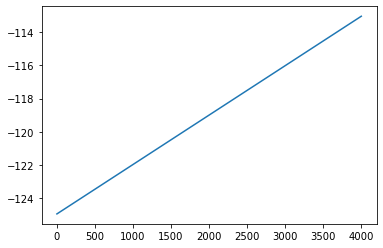

In [65]:
%matplotlib inline
plt.plot(lons['20140110'].data)


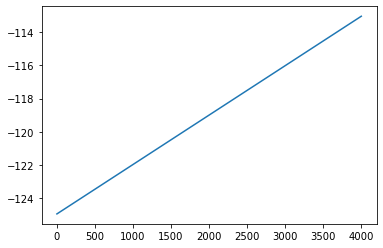

In [66]:
lonPlot = plt.plot(lons['20140110'])
lonPlot

In [67]:
#lats['20140110'][0]
lons['20140110'][0]

-124.94047619022581

In [68]:
latlng = s2.S2LatLng_FromDegrees(lats['20140110'][0], lons['20140110'][0])
cell = s2.S2CellId(latlng)
cell.level()
while cell.level() > 9:
    cell = cell.parent()
cell.level()

9

In [69]:
cell.id()

6114309395271647232

In [70]:
latlng = s2.S2LatLng_FromDegrees(lats['20140110'][1], lons['20140110'][0])
cell2 = s2.S2CellId(latlng)
cell2.level()
while cell2.level() > 9:
    cell2 = cell2.parent()
cell2.level()

9

In [71]:
cell2.id()

6114309395271647232

In [72]:
cell.id() == cell2.id()

True

In [73]:
latlng = s2.S2LatLng_FromDegrees(lats['20140110'][1], lons['20140110'][1])
cell3 = s2.S2CellId(latlng)
cell3.level()
while cell3.level() > 9:
    cell3 = cell3.parent()
cell3.level()

9

In [74]:
cell3.id() == cell.id()

True

### Build dataframe of s2 cell id, fapar stats

In [75]:
 lats['20140110'][0:10]

masked_array(data=[42.05357142858006, 42.05059523810387,
                   42.04761904762768, 42.04464285715149, 42.0416666666753,
                   42.03869047619911, 42.03571428572292,
                   42.03273809524673, 42.02976190477054,
                   42.02678571429435],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value=1e+20)

In [76]:
year = str(2014)

fapars ={}
for filename, fullpath in picklefiles.items():
    if filename.startswith('FAPAR'):
        dateStart = filename.find(str(year))
        date = filename[dateStart:dateStart+8]
        
        with open(fullpath, 'rb') as f:
            fapar = pickle.load(f)
        fapars[date] = fapar

In [77]:
fapars[date]

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., 0.012000000104308128, 0.012000000104308128,
         0.012000000104308128],
        [--, --, --, ..., 0.012000000104308128, 0.01600000075995922,
         0.012000000104308128],
        [--, --, --, ..., 0.012000000104308128, 0.012000000104308128,
         0.012000000104308128]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False]],
  fill_value=255.0,
  dtype=float32)

In [80]:
# Create tuples of x,y pairs for each index in image, should be *ahem 4000*  3750 x 3500 in length
date = '20140110'
latArray = lats[date][0:1000]  # taking only the first 1000 as a test
lonArray = lons[date][0:1000]  # taking only the first 1000 as a test
fapar = fapars[date]
mask = fapars[date].mask

latLonLookupList = []

for idxLat, lat in enumerate(latArray):
    for idxLon, lon in enumerate(lonArray):
        latlng = s2.S2LatLng_FromDegrees(lat, lon)
        cell = s2.S2CellId(latlng)
        cell9 = cell.parent(9)
        cell10 = cell.parent(10)
        cell11 = cell.parent(11)
        latLonLookupList.append((idxLat, lat, idxLon, lon, fapar[idxLon, idxLat], fapar.mask[idxLon, idxLat], 9, cell9.ToToken()))
        latLonLookupList.append((idxLat, lat, idxLon, lon, fapar[idxLon, idxLat], fapar.mask[idxLon, idxLat], 10, cell10.ToToken()))
        latLonLookupList.append((idxLat, lat, idxLon, lon, fapar[idxLon, idxLat], fapar.mask[idxLon, idxLat], 11, cell11.ToToken()))

latLonLookupDF = pd.DataFrame(latLonLookupList, columns= ['latIdx', 'lat', 'lonIdx', 'lon', 'faparVal', 'faparMask', 'S2Level', 'S2_Cells_I'])
latLonLookupDF.head()

#list(mapTuples(latArray[i], lonArray[j]))


latIdx        lat  lonIdx         lon faparVal  faparMask  S2Level  \
0       0  42.053571       0 -124.940476       --       True        9   
1       0  42.053571       0 -124.940476       --       True       10   
2       0  42.053571       0 -124.940476       --       True       11   
3       0  42.053571       1 -124.937500       --       True        9   
4       0  42.053571       1 -124.937500       --       True       10   

  S2_Cells_I  
0     54da64  
1     54da61  
2    54da60c  
3     54da64  
4     54da61

In [81]:
len(latLonLookupDF)

3000000

#### Test joining syntax.
Note the first few cells are too high in latitude to be in California, so skip down a ways

In [82]:
#test joining
ca_s2_df.loc[ca_s2_df['S2_Cells_I']=='54da64']

Empty GeoDataFrame
Columns: [CWA, NAME, STATE_ZONE, FE_AREA, AREA, WF_cum_are, FZ_grp, S2_Cells_I, geometry]
Index: []

In [83]:
#test joining
any(ca_s2_df.loc[ca_s2_df['S2_Cells_I']=='54da61'])

True

In [84]:
#test joining
ca_s2_df.loc[ca_s2_df['S2_Cells_I']=='54da60c']

Empty GeoDataFrame
Columns: [CWA, NAME, STATE_ZONE, FE_AREA, AREA, WF_cum_are, FZ_grp, S2_Cells_I, geometry]
Index: []

In [85]:
type(latLonLookupDF)

pandas.core.frame.DataFrame

In [86]:
type(ca_s2_df)

geopandas.geodataframe.GeoDataFrame

In [87]:
ca_s2_df['mergeKey'] = ca_s2_df.S2_Cells_I.astype(str)

In [88]:
ca_s2_df.mergeKey.dtype

dtype('O')

In [89]:
any(pd.isnull(ca_s2_df.mergeKey))

False

In [90]:
latLonLookupDF['mergeKey'] = latLonLookupDF['S2_Cells_I'].astype(str)

In [91]:
latLonLookupDF.mergeKey.dtype

dtype('O')

In [92]:
any(pd.isnull(latLonLookupDF.mergeKey))

False

In [93]:
ca_s2_df.head()

CWA                        NAME STATE_ZONE FE_AREA      AREA  WF_cum_are  \
0  VEF  Death Valley National Park      CA227      ee  2.001602   37.487592   
1  VEF  Death Valley National Park      CA227      ee  2.001602   37.487592   
2  VEF  Death Valley National Park      CA227      ee  2.001602   37.487592   
3  VEF  Death Valley National Park      CA227      ee  2.001602   37.487592   
4  VEF  Death Valley National Park      CA227      ee  2.001602   37.487592   

  FZ_grp S2_Cells_I                                           geometry  \
0    low     80b8a4  POLYGON ((-116.9852421934208 36.92851788893871...   
1    low     80b8ac  POLYGON ((-117.1735315927328 36.88229296981148...   
2    low     80b8b4  POLYGON ((-117.1735315927328 37.04169221702246...   
3    low     80be44  POLYGON ((-118.2994349957241 37.38986432048104...   
4    low     80be4c  POLYGON ((-118.2994349957241 37.23225420438236...   

  mergeKey  
0   80b8a4  
1   80b8ac  
2   80b8b4  
3   80be44  
4   80be4c

In [94]:
latLonLookupDF.head()

latIdx        lat  lonIdx         lon faparVal  faparMask  S2Level  \
0       0  42.053571       0 -124.940476       --       True        9   
1       0  42.053571       0 -124.940476       --       True       10   
2       0  42.053571       0 -124.940476       --       True       11   
3       0  42.053571       1 -124.937500       --       True        9   
4       0  42.053571       1 -124.937500       --       True       10   

  S2_Cells_I mergeKey  
0     54da64   54da64  
1     54da61   54da61  
2    54da60c  54da60c  
3     54da64   54da64  
4     54da61   54da61

In [95]:
merged = ca_s2_df.merge(latLonLookupDF, how='inner', on= 'mergeKey', left_index = True)

In [96]:

merged.head()

CWA         NAME STATE_ZONE FE_AREA      AREA  WF_cum_are FZ_grp  \
924  EKA  Upper Smith      CA203      nw  0.122278         0.0    low   
927  EKA  Upper Smith      CA203      nw  0.122278         0.0    low   
930  EKA  Upper Smith      CA203      nw  0.122278         0.0    low   
933  EKA  Upper Smith      CA203      nw  0.122278         0.0    low   
936  EKA  Upper Smith      CA203      nw  0.122278         0.0    low   

    S2_Cells_I_x                                           geometry mergeKey  \
924       54d004  POLYGON ((-123.858528986183 42.13322239787939,...   54d004   
927       54d004  POLYGON ((-123.858528986183 42.13322239787939,...   54d004   
930       54d004  POLYGON ((-123.858528986183 42.13322239787939,...   54d004   
933       54d004  POLYGON ((-123.858528986183 42.13322239787939,...   54d004   
936       54d004  POLYGON ((-123.858528986183 42.13322239787939,...   54d004   

     latIdx        lat  lonIdx         lon faparVal  faparMask  S2Level  \
924       0  42.053571     308 -124.023810       --       True        9   
927       0  42.053571     309 -124.020833       --       True        9   
930       0  42.053571     310 -124.017857       --       True        9   
933       0  42.053571     311 -124.014881       --       True        9   
936       0  42.053571     312 -124.011905       --       True        9   

    S2_Cells_I_y  
924       54d004  
927       54d004  
930       54d004  
933       54d004  
936       54d004

In [97]:
merged.head(30)

CWA         NAME STATE_ZONE FE_AREA      AREA  WF_cum_are FZ_grp  \
924   EKA  Upper Smith      CA203      nw  0.122278         0.0    low   
927   EKA  Upper Smith      CA203      nw  0.122278         0.0    low   
930   EKA  Upper Smith      CA203      nw  0.122278         0.0    low   
933   EKA  Upper Smith      CA203      nw  0.122278         0.0    low   
936   EKA  Upper Smith      CA203      nw  0.122278         0.0    low   
939   EKA  Upper Smith      CA203      nw  0.122278         0.0    low   
942   EKA  Upper Smith      CA203      nw  0.122278         0.0    low   
945   EKA  Upper Smith      CA203      nw  0.122278         0.0    low   
948   EKA  Upper Smith      CA203      nw  0.122278         0.0    low   
951   EKA  Upper Smith      CA203      nw  0.122278         0.0    low   
954   EKA  Upper Smith      CA203      nw  0.122278         0.0    low   
957   EKA  Upper Smith      CA203      nw  0.122278         0.0    low   
960   EKA  Upper Smith      CA203      nw  0.122278         0.0    low   
963   EKA  Upper Smith      CA203      nw  0.122278         0.0    low   
966   EKA  Upper Smith      CA203      nw  0.122278         0.0    low   
969   EKA  Upper Smith      CA203      nw  0.122278         0.0    low   
972   EKA  Upper Smith      CA203      nw  0.122278         0.0    low   
975   EKA  Upper Smith      CA203      nw  0.122278         0.0    low   
978   EKA  Upper Smith      CA203      nw  0.122278         0.0    low   
981   EKA  Upper Smith      CA203      nw  0.122278         0.0    low   
984   EKA  Upper Smith      CA203      nw  0.122278         0.0    low   
987   EKA  Upper Smith      CA203      nw  0.122278         0.0    low   
990   EKA  Upper Smith      CA203      nw  0.122278         0.0    low   
993   EKA  Upper Smith      CA203      nw  0.122278         0.0    low   
996   EKA  Upper Smith      CA203      nw  0.122278         0.0    low   
999   EKA  Upper Smith      CA203      nw  0.122278         0.0    low   
1002  EKA  Upper Smith      CA203      nw  0.122278         0.0    low   
1005  EKA  Upper Smith      CA203      nw  0.122278         0.0    low   
1008  EKA  Upper Smith      CA203      nw  0.122278         0.0    low   
1011  EKA  Upper Smith      CA203      nw  0.122278         0.0    low   

     S2_Cells_I_x                                           geometry mergeKey  \
924        54d004  POLYGON ((-123.858528986183 42.13322239787939,...   54d004   
927        54d004  POLYGON ((-123.858528986183 42.13322239787939,...   54d004   
930        54d004  POLYGON ((-123.858528986183 42.13322239787939,...   54d004   
933        54d004  POLYGON ((-123.858528986183 42.13322239787939,...   54d004   
936        54d004  POLYGON ((-123.858528986183 42.13322239787939,...   54d004   
939        54d004  POLYGON ((-123.858528986183 42.13322239787939,...   54d004   
942        54d004  POLYGON ((-123.858528986183 42.13322239787939,...   54d004   
945        54d004  POLYGON ((-123.858528986183 42.13322239787939,...   54d004   
948        54d004  POLYGON ((-123.858528986183 42.13322239787939,...   54d004   
951        54d004  POLYGON ((-123.858528986183 42.13322239787939,...   54d004   
954        54d004  POLYGON ((-123.858528986183 42.13322239787939,...   54d004   
957        54d004  POLYGON ((-123.858528986183 42.13322239787939,...   54d004   
960        54d004  POLYGON ((-123.858528986183 42.13322239787939,...   54d004   
963        54d004  POLYGON ((-123.858528986183 42.13322239787939,...   54d004   
966        54d004  POLYGON ((-123.858528986183 42.13322239787939,...   54d004   
969        54d004  POLYGON ((-123.858528986183 42.13322239787939,...   54d004   
972        54d004  POLYGON ((-123.858528986183 42.13322239787939,...   54d004   
975        54d004  POLYGON ((-123.858528986183 42.13322239787939,...   54d004   
978        54d004  POLYGON ((-123.858528986183 42.13322239787939,...   54d004   
981        54d004  POLYGON ((-123.858528986183 42.13322239787939,...   54d004   
984       

 ...]

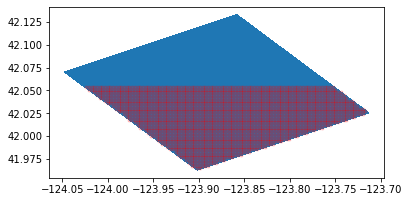

In [98]:
merged[merged['mergeKey'] == '54d004']['geometry'].plot()
plt.plot([merged[merged['mergeKey'] == '54d004']['lon']], [merged[merged['mergeKey'] == '54d004']['lat']], 'r.', alpha =0.2)

In [107]:
# NOTE I had a typo in pickle_sat.py in creating the grid of longitudes in the initial processing.
# Further, the FAPAR file gives lat (N-S) then lon (E-W)
# so its shape is 3500 x 3750  (lat by lon)
#
#
# The FAPAR file ranges from lons[18500:22250] 
# while the lon file ranges from [18500:22500], 
# difference of 250 in the second dimension
    
    # Filter to a coarse grid containing California:
        # California is between West 125 (-125 lon) and 114 (-114 lon), and 32 N and 42 N (32 and 42 lat)
#        ca_W = lons[18500]
#        ca_E = lons[22250]
#        ca_N = lats[12750]
#        ca_S = lats[16250]
#        latsCa= lats[12750:16250]
#        lonsCa = lons[18500:22500]
#        faparCa = fapar[12750:16250,18500:22250]



#%%timeit
# Create tuples of x,y pairs for each index in image, should be 4000 x 3500 in length
date = '20140110'
latArray = lats[date]
lonArray = lons[date]
fapar = fapars[date]
mask = fapars[date].mask

latLonLookupList = []

for idxLat, lat in enumerate(latArray):
    for idxLon, lon in enumerate(lonArray[0:-250]):
        latlng = s2.S2LatLng_FromDegrees(lat, lon)
        cell = s2.S2CellId(latlng)
        cell9 = cell.parent(9)
        cell10 = cell.parent(10)
        cell11 = cell.parent(11)
        latLonLookupList.append((idxLat, lat, idxLon, lon, fapar[idxLat, idxLon], fapar.mask[idxLat, idxLon], 9, cell9.ToToken()))
        latLonLookupList.append((idxLat, lat, idxLon, lon, fapar[idxLat, idxLon], fapar.mask[idxLat, idxLon], 10, cell10.ToToken()))
        latLonLookupList.append((idxLat, lat, idxLon, lon, fapar[idxLat, idxLon], fapar.mask[idxLat, idxLon], 11, cell11.ToToken()))

latLonLookupDF = pd.DataFrame(latLonLookupList, columns= ['latIdx', 'lat', 'lonIdx', 'lon', 'faparVal', 'faparMask', 'S2Level', 'S2_Cells_I'])
latLonLookupDF['mergeKey'] = latLonLookupDF.S2_Cells_I.astype(str)

ca_s2_df['mergeKey'] = ca_s2_df.S2_Cells_I.astype(str)
merged = ca_s2_df.merge(latLonLookupDF, how='inner', on= 'mergeKey', left_index = True)
merged.head()


NameError: name 'latLonLookup' is not defined

In [109]:
latLonLookupDF = pd.DataFrame(latLonLookupList, columns= ['latIdx', 'lat', 'lonIdx', 'lon', 'faparVal', 'faparMask', 'S2Level', 'S2_Cells_I'])

latLonLookupDF['mergeKey'] = latLonLookupDF.S2_Cells_I.astype(str)
ca_s2_df['mergeKey'] = ca_s2_df.S2_Cells_I.astype(str)
merged = ca_s2_df.merge(latLonLookupDF, how='inner', on= 'mergeKey', left_index = True)
merged.head()


CWA                        NAME STATE_ZONE FE_AREA      AREA  \
19211955  VEF  Death Valley National Park      CA227      ee  2.001602   
19211958  VEF  Death Valley National Park      CA227      ee  2.001602   
19223193  VEF  Death Valley National Park      CA227      ee  2.001602   
19223196  VEF  Death Valley National Park      CA227      ee  2.001602   
19223199  VEF  Death Valley National Park      CA227      ee  2.001602   

          WF_cum_are FZ_grp S2_Cells_I_x  \
19211955   37.487592    low       80b8a4   
19211958   37.487592    low       80b8a4   
19223193   37.487592    low       80b8a4   
19223196   37.487592    low       80b8a4   
19223199   37.487592    low       80b8a4   

                                                   geometry mergeKey  latIdx  \
19211955  POLYGON ((-116.9852421934208 36.92851788893871...   80b8a4    1707   
19211958  POLYGON ((-116.9852421934208 36.92851788893871...   80b8a4    1707   
19223193  POLYGON ((-116.9852421934208 36.92851788893871...   80b8a4    1708   
19223196  POLYGON ((-116.9852421934208 36.92851788893871...   80b8a4    1708   
19223199  POLYGON ((-116.9852421934208 36.92851788893871...   80b8a4    1708   

                lat  lonIdx         lon faparVal  faparMask  S2Level  \
19211955  36.973214    2735 -116.800595    0.032      False        9   
19211958  36.973214    2736 -116.797619     0.04      False        9   
19223193  36.970238    2731 -116.812500    0.032      False        9   
19223196  36.970238    2732 -116.809524    0.036      False        9   
19223199  36.970238    2733 -116.806548    0.048      False        9   

         S2_Cells_I_y  
19211955       80b8a4  
19211958       80b8a4  
19223193       80b8a4  
19223196       80b8a4  
19223199       80b8a4

In [110]:
merged[['latIdx', 'lonIdx']].max()

latIdx    3223
lonIdx    3691
dtype: int64

In [114]:
# Tries to plot all the geometries over and over for each pixel, takes forever.  don't do
#fig = plt.figure()
#title_obj = plt.title(year) #get the title property handler
#merged['geometry'].plot()
#im = plt.imshow(fapars['20140110'])
#plt.show()

In [115]:
# Groupby s2Cell ID, take mean, median, min, max, stddev, and N of FAPAR_val
faparMerged = merged[['mergeKey', 'latIdx', 'lat', 'lonIdx', 'lon', 'faparVal', 'faparMask']]
faparMerged.head()


mergeKey  latIdx        lat  lonIdx         lon faparVal  faparMask
19211955   80b8a4    1707  36.973214    2735 -116.800595    0.032      False
19211958   80b8a4    1707  36.973214    2736 -116.797619     0.04      False
19223193   80b8a4    1708  36.970238    2731 -116.812500    0.032      False
19223196   80b8a4    1708  36.970238    2732 -116.809524    0.036      False
19223199   80b8a4    1708  36.970238    2733 -116.806548    0.048      False

In [116]:
agged = faparMerged.groupby('mergeKey').agg(['min', 'max', 'mean', 'median', 'std', 'count'])
agged.head()

In [117]:
agged.head()

latIdx                                              lat             \
            min max       mean median       std count        min        max   
mergeKey                                                                      
54c934        0  32  11.703905   11.0  7.714542  2023  41.958333  42.053571   
54c9354      19  32  25.145631   25.0  3.036069   206  41.958333  41.997024   
54c935c      14  27  20.281553   20.0  3.045725   206  41.973214  42.011905   
54c9364       9  22  15.409756   15.0  3.061126   205  41.988095  42.026786   
54c9414       8  22  15.014563   15.0  3.070677   206  41.988095  42.029762   

                                ...         lon                              \
               mean     median  ...        mean      median       std count   
mergeKey                        ...                                           
54c934    42.018738  42.020833  ... -121.457023 -121.461310  0.068523  2023   
54c9354   41.978733  41.979167  ... -121.487315 -121.488095  0.017116   206   
54c935c   41.993210  41.994048  ... -121.439913 -121.440476  0.017146   206   
54c9364   42.007709  42.008929  ... -121.392697 -121.392857  0.016824   205   
54c9414   42.008885  42.008929  ... -121.134348 -121.133929  0.016967   206   

         faparMask                                          
               min    max      mean median       std count  
mergeKey                                                    
54c934       False   True  0.000989    0.0  0.031435  2023  
54c9354      False  False  0.000000    0.0  0.000000   206  
54c935c      False  False  0.000000    0.0  0.000000   206  
54c9364      False  False  0.000000    0.0  0.000000   205  
54c9414      False   True  0.033981    0.0  0.181621   206  

[5 rows x 30 columns]

In [118]:
agged.columns

MultiIndex(levels=[['latIdx', 'lat', 'lonIdx', 'lon', 'faparMask'], ['min', 'max', 'mean', 'median', 'std', 'count']],
           codes=[[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4], [0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5]])

In [120]:
faparMerged['faparVal'].head()

19211955    0.032
19211958     0.04
19223193    0.032
19223196    0.036
19223199    0.048
Name: faparVal, dtype: object

In [122]:
faparMerged[['mergeKey', 'faparVal']].head()

mergeKey faparVal
19211955   80b8a4    0.032
19211958   80b8a4     0.04
19223193   80b8a4    0.032
19223196   80b8a4    0.036
19223199   80b8a4    0.048

In [128]:
faparMerged[['mergeKey', 'faparVal']].groupby('mergeKey').agg(['min', 'max', 'mean']).head()

ValueError: no results

In [160]:
# Define slightly customized aggregation functions

def myMedian(x):
    return(pd.DataFrame.median(x, skipna=True))

def myMean(x):
    return(np.ma.mean(x))

def myStd(x):
    return(np.ma.std(x))


In [161]:
faparMerged[['mergeKey', 'faparVal']].groupby('mergeKey').

/home/scott/anaconda3/envs/sat/lib/python3.7/site-packages/pandas/core/nanops.py:527: UserWarning: Warning: converting a masked element to nan.
  values = values.astype('f8')
/home/scott/anaconda3/envs/sat/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1076: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


faparVal                                          
              min    max    myMean myMedian     myStd count
mergeKey                                                   
54c934      0.024  0.616  0.000000    0.120  0.000000  2023
54c9354     0.024  0.240  0.090136    0.084  0.041195   206
54c935c     0.036  0.260  0.109748    0.104  0.040875   206
54c9364     0.044  0.312  0.120254    0.120  0.049544   205
54c9414     0.032  0.228  0.000000    0.144  0.000000   206
54c9424     0.092  0.424  0.173034    0.160  0.059440   205
54c942c     0.056  0.260  0.117463    0.104  0.043523   205
54c9434     0.068  0.272  0.113471    0.108  0.031778   204
54c943c     0.068  0.256  0.133177    0.128  0.037400   204
54c9444     0.056  0.384  0.238686    0.248  0.073753   204
54c944c     0.068  0.288  0.156738    0.160  0.054234   206
54c9454     0.052  0.304  0.146699    0.108  0.073131   206
54c945c     0.100  0.308  0.228059    0.244  0.051511   203
54c9464     0.108  0.420  0.233049    0.230  0.072085   206
54c946c     0.056  0.408  0.213171    0.208  0.087153   205
54c947c     0.108  0.552  0.308371    0.324  0.118013   205
54c9484     0.080  0.300  0.180373    0.176  0.043550   204
54c948c     0.076  0.288  0.161320    0.148  0.049964   206
54c9494     0.048  0.424  0.127395    0.116  0.053743   205
54c949c     0.032  0.260  0.000000    0.120  0.000000   205
54c94a4     0.032  0.264  0.089573    0.076  0.046306   206
54c94ac     0.020  0.224  0.074118    0.064  0.035804   204
54c94b4     0.012  0.216  0.065647    0.060  0.032437   204
54c94bc     0.028  0.212  0.085020    0.074  0.039374   204
54c94c      0.028  0.132  0.000000    0.088  0.000000  3272
54c94c4     0.028  0.184  0.075883    0.068  0.024242   205
54c94cc     0.024  0.196  0.059429    0.052  0.026859   203
54c94d4     0.032  0.132  0.078010    0.076  0.024054   205
54c94dc     0.028  0.132  0.000000    0.068  0.000000   202
54c94e4     0.032  0.116  0.000000    0.084  0.000000   204
...           ...    ...       ...      ...       ...   ...
80ed2d4     0.212  0.800  0.599478    0.624  0.124866   199
80ed2f      0.064  0.616  0.229090    0.188  0.136813   826
80ed31      0.000  0.000  0.000000    0.396  0.000000   828
80ed33      0.072  0.796  0.360946    0.396  0.162207   824
80ed35      0.000  0.000  0.000000    0.396  0.000000   822
80ee9f      0.000  0.000  0.000000    0.404  0.000000   837
80eea1      0.028  0.680  0.278662    0.252  0.177020   837
80eea3      0.000  0.000  0.000000    0.408  0.000000   839
80eea34     0.056  0.484  0.338594    0.404  0.113829   202
80eea3c     0.032  0.572  0.182286    0.132  0.116360   203
80eea44     0.088  0.652  0.387352    0.400  0.148931   216
80eea4c     0.052  0.520  0.243389    0.182  0.152191   216
80eea5      0.052  0.652  0.317140    0.348  0.163663   838
80eea54     0.052  0.652  0.252788    0.240  0.142901   203
80eea5c     0.084  0.652  0.385261    0.412  0.148630   203
80eea7      0.072  0.660  0.223289    0.192  0.112759   838
80eea9      0.052  0.604  0.230026    0.176  0.141935   837
80eeab      0.032  0.584  0.197175    0.180  0.085445   837
80eead      0.048  0.700  0.255743    0.236  0.141712   840
80eead4     0.072  0.700  0.401439    0.408  0.133584   203
80eeadc     0.068  0.436  0.268389    0.288  0.100520   216
80eeae4     0.056  0.512  0.252158    0.264  0.116794   203
80eeaf      0.056  0.636  0.270624    0.264  0.132740   840
80eeafc     0.068  0.532  0.244037    0.238  0.115134   218
80eeb1c     0.408  0.408  0.000000    0.404  0.000000   203
80eeb24     0.056  0.424  0.316811    0.396  0.116636   217
80eeb2c     0.104  0.484  0.320647    0.334  0.094441   204
80eed4      0.000  0.000  0.000000    0.400  0.000000  3371
80eedc      0.000  0.000  0.000000    0.408  0.000000  3365
80ef2c      0.000  0.000  0.000000    0.420  0.000000  3377

[10643 rows x 6 columns]

In [164]:
agged = faparMerged.groupby('mergeKey').agg(['min', 'max', myMean, myMedian, myStd, 'size', 'count', 'nunique'])
agged

latIdx                                                             \
            min   max       myMean myMedian      myStd  size count nunique   
mergeKey                                                                     
54c934        0    32    11.703905     11.0   7.712635  2023  2023      33   
54c9354      19    32    25.145631     25.0   3.028691   206   206      14   
54c935c      14    27    20.281553     20.0   3.038323   206   206      14   
54c9364       9    22    15.409756     15.0   3.053651   205   205      14   
54c9414       8    22    15.014563     15.0   3.063214   206   206      15   
54c9424      13    26    19.648780     20.0   3.048160   205   205      14   
54c942c      23    36    29.121951     29.0   3.065108   205   205      14   
54c9434      27    40    33.848039     34.0   3.042420   204   204      14   
54c943c      18    31    24.465686     24.0   3.039575   204   204      14   
54c9444      23    36    29.250000     29.0   3.055251   204   204      14   
54c944c      32    45    38.660194     39.0   3.064211   206   206      14   
54c9454      37    50    43.412621     43.0   3.052873   206   206      14   
54c945c      28    40    34.009852     34.0   3.017176   203   203      13   
54c9464      18    31    24.626214     25.0   3.083166   206   206      14   
54c946c      13    26    19.819512     20.0   3.033409   205   205      14   
54c947c       9    22    15.209756     15.0   3.063539   205   205      14   
54c9484      14    26    20.019608     20.0   3.038899   204   204      13   
54c948c      23    36    29.378641     29.0   3.078635   206   206      14   
54c9494      28    41    34.239024     34.0   3.048620   205   205      14   
54c949c      18    31    24.790244     25.0   3.050774   205   205      14   
54c94a4      23    36    29.679612     30.0   3.047245   206   206      14   
54c94ac      28    41    34.539216     35.0   3.037903   204   204      14   
54c94b4      37    50    43.857843     44.0   3.058961   204   204      14   
54c94bc      33    46    39.078431     39.0   3.037950   204   204      14   
54c94c       14    69    41.307457     41.0  12.176658  3272  3272      56   
54c94c4      42    55    48.468293     48.0   3.058011   205   205      14   
54c94cc      47    60    53.211823     53.0   3.046351   203   203      14   
54c94d4      56    69    62.570732     63.0   3.063733   205   205      14   
54c94dc      51    64    57.816832     58.0   3.026470   202   202      14   
54c94e4      47    60    53.034314     53.0   3.026646   204   204      14   
...         ...   ...          ...      ...        ...   ...   ...     ...   
80ed2d4    2136  2152  2144.261307   2144.0   4.027800   199   199      17   
80ed2f     2158  2192  2175.311138   2175.0   8.093808   826   826      35   
80ed31     2167  2201  2184.141304   2184.0   8.119017   828   828      35   
80ed33     2140  2175  2157.500000   2157.5   8.090657   824   824      36   
80ed35     2149  2184  2166.474453   2166.0   8.083729   822   822      36   
80ee9f     2517  2551  2534.161290   2534.0   8.165348   837   837      35   
80eea1     2509  2543  2525.645161   2526.0   8.159229   837   837      35   
80eea3     2536  2570  2552.682956   2553.0   8.186421   839   839      35   
80eea34    2549  2565  2557.222772   2557.0   4.060785   202   202      17   
80eea3c    2536  2552  2543.743842   2544.0   4.078467   203   203      17   
80eea44    2531  2548  2539.435185   2539.0   4.091032   216   216      18   
80eea4c    2545  2561  2552.939815   2553.0   4.088272   216   216      17   
80eea5     2527  2561  2544.143198   2544.0   8.177244   838   838      35   
80eea54    2541  2557  2548.743842   2549.0   4.078467   203   203      17   
80eea5c    2527  2543  2535.192118   2535.0   4.074133   203   203      17   
80eea7     2500  2534  2517.114558   2517.0   8.177696   838   838      35   
80eea9     2492  2526  2508.645161   2509.0   8.159229   837   837      35   
80eeab     2483  2517  2500.161

In [165]:
agged.to_csv('~/sat_aggs/20140110_agg.csv')

In [166]:
newAgged = pd.read_csv('~/sat_aggs/20140110_agg.csv')
newAgged

Unnamed: 0 latIdx latIdx.1            latIdx.2  latIdx.3  \
0            NaN    min      max              myMean  myMedian   
1       mergeKey    NaN      NaN                 NaN       NaN   
2         54c934      0       32  11.703905091448345      11.0   
3        54c9354     19       32  25.145631067961165      25.0   
4        54c935c     14       27  20.281553398058254      20.0   
5        54c9364      9       22  15.409756097560976      15.0   
6        54c9414      8       22  15.014563106796116      15.0   
7        54c9424     13       26  19.648780487804878      20.0   
8        54c942c     23       36  29.121951219512194      29.0   
9        54c9434     27       40   33.84803921568628      34.0   
10       54c943c     18       31  24.465686274509803      24.0   
11       54c9444     23       36               29.25      29.0   
12       54c944c     32       45   38.66019417475728      39.0   
13       54c9454     37       50    43.4126213592233      43.0   
14       54c945c     28       40   34.00985221674877      34.0   
15       54c9464     18       31   24.62621359223301      25.0   
16       54c946c     13       26  19.819512195121952      20.0   
17       54c947c      9       22  15.209756097560975      15.0   
18       54c9484     14       26  20.019607843137255      20.0   
19       54c948c     23       36   29.37864077669903      29.0   
20       54c9494     28       41  34.239024390243905      34.0   
21       54c949c     18       31  24.790243902439023      25.0   
22       54c94a4     23       36  29.679611650485437      30.0   
23       54c94ac     28       41   34.53921568627451      35.0   
24       54c94b4     37       50    43.8578431372549      44.0   
25       54c94bc     33       46   39.07843137254902      39.0   
26        54c94c     14       69  41.307457212713935      41.0   
27       54c94c4     42       55   48.46829268292683      48.0   
28       54c94cc     47       60   53.21182266009852      53.0   
29       54c94d4     56       69   62.57073170731707      63.0   
...          ...    ...      ...                 ...       ...   
10615    80ed2d4   2136     2152   2144.261306532663    2144.0   
10616     80ed2f   2158     2192   2175.311138014528    2175.0   
10617     80ed31   2167     2201   2184.141304347826    2184.0   
10618     80ed33   2140     2175              2157.5    2157.5   
10619     80ed35   2149     2184  2166.4744525547444    2166.0   
10620     80ee9f   2517     2551  2534.1612903225805    2534.0   
10621     80eea1   2509     2543  2525.6451612903224    2526.0   
10622     80eea3   2536     2570  2552.6829558998807    2553.0   
10623    80eea34   2549     2565  2557.2227722772277    2557.0   
10624    80eea3c   2536     2552   2543.743842364532    2544.0   
10625    80eea44   2531     2548   2539.435185185185    2539.0   
10626    80eea4c   2545     2561   2552.939814814815    2553.0   
10627     80eea5   2527     2561  2544.1431980906923    2544.0   
10628    80eea54   2541     2557   2548.743842364532    2549.0   
10629    80eea5c   2527     2543   2535.192118226601    2535.0   
10630     80eea7   2500     2534  2517.1145584725537    2517.0   
10631     80eea9   2492     2526  2508.6451612903224    2509.0   
10632     80eeab   2483     2517  2500.1612903225805    2500.0   
10633     80eead   2510     2544  2527.2107142857144    2527.0   
10634    80eead4   2524     2540   2531.807881773399    2532.0   
10635    80eeadc   2528     2544   2536.060185185185    2536.0   
10636    80eeae4   2532     2548   2540.256157635468    2540.0   
10637     80eeaf   2519     2553  2535.6964285714284    2536.0   
10638    80eeafc   2536     2553              2544.5    2544.5   
10639    80eeb1c   2546     2562   2553.807881773399    2554.0   
10640    80eeb24   2541     2558   2549.599078341014    2550.0   
10641    80eeb2c   2537     2554  2545.3627450980393    2545.0   
10642     80eed4   2646     2716   2680.671907445862    2681.0   
10643     80eedc   2663     2732   2697.506092

In [167]:
date

'20140110'

In [169]:
outPath = '~/sat_aggs/'
fullPath = outPath + date + '_agg.csv'
fullPath

'~/sat_aggs/20140110_agg.csv'

In [170]:
agged['date'] = date

In [171]:
agged.head()

latIdx                                                        \
            min max     myMean myMedian     myStd  size count nunique   
mergeKey                                                                
54c934        0  32  11.703905     11.0  7.712635  2023  2023      33   
54c9354      19  32  25.145631     25.0  3.028691   206   206      14   
54c935c      14  27  20.281553     20.0  3.038323   206   206      14   
54c9364       9  22  15.409756     15.0  3.053651   205   205      14   
54c9414       8  22  15.014563     15.0  3.063214   206   206      15   

                lat             ... faparVal faparMask                   \
                min        max  ...  nunique       min    max    myMean   
mergeKey                        ...                                       
54c934    41.958333  42.053571  ...      156     False   True  0.000989   
54c9354   41.958333  41.997024  ...       44     False  False  0.000000   
54c935c   41.973214  42.011905  ...       44     False  False  0.000000   
54c9364   41.988095  42.026786  ...       49     False  False  0.000000   
54c9414   41.988095  42.029762  ...       57     False   True  0.033981   

                                                     date  
         myMedian     myStd  size count nunique            
mergeKey                                                   
54c934        0.0  0.031427  2023  2023       2  20140110  
54c9354       0.0  0.000000   206   206       1  20140110  
54c935c       0.0  0.000000   206   206       1  20140110  
54c9364       0.0  0.000000   205   205       1  20140110  
54c9414       0.0  0.181179   206   206       2  20140110  

[5 rows x 49 columns]

In [173]:
agged.columns.get_level_values(0)

Index(['latIdx', 'latIdx', 'latIdx', 'latIdx', 'latIdx', 'latIdx', 'latIdx',
       'latIdx', 'lat', 'lat', 'lat', 'lat', 'lat', 'lat', 'lat', 'lat',
       'lonIdx', 'lonIdx', 'lonIdx', 'lonIdx', 'lonIdx', 'lonIdx', 'lonIdx',
       'lonIdx', 'lon', 'lon', 'lon', 'lon', 'lon', 'lon', 'lon', 'lon',
       'faparVal', 'faparVal', 'faparVal', 'faparVal', 'faparVal', 'faparVal',
       'faparVal', 'faparVal', 'faparMask', 'faparMask', 'faparMask',
       'faparMask', 'faparMask', 'faparMask', 'faparMask', 'faparMask',
       'date'],
      dtype='object')

In [174]:
agged.columns.values

array([('latIdx', 'min'), ('latIdx', 'max'), ('latIdx', 'myMean'),
       ('latIdx', 'myMedian'), ('latIdx', 'myStd'), ('latIdx', 'size'),
       ('latIdx', 'count'), ('latIdx', 'nunique'), ('lat', 'min'),
       ('lat', 'max'), ('lat', 'myMean'), ('lat', 'myMedian'),
       ('lat', 'myStd'), ('lat', 'size'), ('lat', 'count'),
       ('lat', 'nunique'), ('lonIdx', 'min'), ('lonIdx', 'max'),
       ('lonIdx', 'myMean'), ('lonIdx', 'myMedian'), ('lonIdx', 'myStd'),
       ('lonIdx', 'size'), ('lonIdx', 'count'), ('lonIdx', 'nunique'),
       ('lon', 'min'), ('lon', 'max'), ('lon', 'myMean'),
       ('lon', 'myMedian'), ('lon', 'myStd'), ('lon', 'size'),
       ('lon', 'count'), ('lon', 'nunique'), ('faparVal', 'min'),
       ('faparVal', 'max'), ('faparVal', 'myMean'),
       ('faparVal', 'myMedian'), ('faparVal', 'myStd'),
       ('faparVal', 'size'), ('faparVal', 'count'),
       ('faparVal', 'nunique'), ('faparMask', 'min'),
       ('faparMask', 'max'), ('faparMask', 'myMean'),
      

In [176]:
['_'.join(col).strip() for col in agged.columns.values]

['latIdx_min',
 'latIdx_max',
 'latIdx_myMean',
 'latIdx_myMedian',
 'latIdx_myStd',
 'latIdx_size',
 'latIdx_count',
 'latIdx_nunique',
 'lat_min',
 'lat_max',
 'lat_myMean',
 'lat_myMedian',
 'lat_myStd',
 'lat_size',
 'lat_count',
 'lat_nunique',
 'lonIdx_min',
 'lonIdx_max',
 'lonIdx_myMean',
 'lonIdx_myMedian',
 'lonIdx_myStd',
 'lonIdx_size',
 'lonIdx_count',
 'lonIdx_nunique',
 'lon_min',
 'lon_max',
 'lon_myMean',
 'lon_myMedian',
 'lon_myStd',
 'lon_size',
 'lon_count',
 'lon_nunique',
 'faparVal_min',
 'faparVal_max',
 'faparVal_myMean',
 'faparVal_myMedian',
 'faparVal_myStd',
 'faparVal_size',
 'faparVal_count',
 'faparVal_nunique',
 'faparMask_min',
 'faparMask_max',
 'faparMask_myMean',
 'faparMask_myMedian',
 'faparMask_myStd',
 'faparMask_size',
 'faparMask_count',
 'faparMask_nunique',
 'date_']

In [178]:
agged2 = agged.copy()
agged2.columns = ['_'.join(col).strip() for col in agged2.columns.values]
agged2

latIdx_min  latIdx_max  latIdx_myMean  latIdx_myMedian  \
mergeKey                                                           
54c934             0          32      11.703905             11.0   
54c9354           19          32      25.145631             25.0   
54c935c           14          27      20.281553             20.0   
54c9364            9          22      15.409756             15.0   
54c9414            8          22      15.014563             15.0   
54c9424           13          26      19.648780             20.0   
54c942c           23          36      29.121951             29.0   
54c9434           27          40      33.848039             34.0   
54c943c           18          31      24.465686             24.0   
54c9444           23          36      29.250000             29.0   
54c944c           32          45      38.660194             39.0   
54c9454           37          50      43.412621             43.0   
54c945c           28          40      34.009852             34.0   
54c9464           18          31      24.626214             25.0   
54c946c           13          26      19.819512             20.0   
54c947c            9          22      15.209756             15.0   
54c9484           14          26      20.019608             20.0   
54c948c           23          36      29.378641             29.0   
54c9494           28          41      34.239024             34.0   
54c949c           18          31      24.790244             25.0   
54c94a4           23          36      29.679612             30.0   
54c94ac           28          41      34.539216             35.0   
54c94b4           37          50      43.857843             44.0   
54c94bc           33          46      39.078431             39.0   
54c94c            14          69      41.307457             41.0   
54c94c4           42          55      48.468293             48.0   
54c94cc           47          60      53.211823             53.0   
54c94d4           56          69      62.570732             63.0   
54c94dc           51          64      57.816832             58.0   
54c94e4           47          60      53.034314             53.0   
...              ...         ...            ...              ...   
80ed2d4         2136        2152    2144.261307           2144.0   
80ed2f          2158        2192    2175.311138           2175.0   
80ed31          2167        2201    2184.141304           2184.0   
80ed33          2140        2175    2157.500000           2157.5   
80ed35          2149        2184    2166.474453           2166.0   
80ee9f          2517        2551    2534.161290           2534.0   
80eea1          2509        2543    2525.645161           2526.0   
80eea3          2536        2570    2552.682956           2553.0   
80eea34         2549        2565    2557.222772           2557.0   
80eea3c         2536        2552    2543.743842           2544.0   
80eea44         2531        2548    2539.435185           2539.0   
80eea4c         2545        2561    2552.939815           2553.0   
80eea5          2527        2561    2544.143198           2544.0   
80eea54         2541        2557    2548.743842           2549.0   
80eea5c         2527        2543    2535.192118           2535.0   
80eea7          2500        2534    2517.114558           2517.0   
80eea9          2492        2526    2508.645161           2509.0   
80eeab          2483        2517    2500.161290           2500.0   
80eead          2510        2544    2527.210714           2527.0   
80eead4         2524        2540    2531.807882           2532.0   
80eeadc         2528        2544    2536.060185           2536.0   
80eeae4         2532        2548    2540.256158           2540.0   
80eeaf          2519        2553    2535.696429           2536.0   
80eeafc         2536        2553    2544.500000           2544.5   
80eeb1c         2546        2562    2553.807882           2554.0   
80eeb24         2541        2558    2549.599078           2550.0  

In [180]:
outPath = '~/sat_aggs/'
fullPath = outPath + date + '_agg.csv'
fullPath
agged2.to_csv(fullPath)

In [22]:
years = range(2014, 2020)
year = str(2014)
#for year in years:

# Lat / lon aren't dependent on year so I really only need the first entry, but this should be quick anyway

lats ={}
for filename, fullpath in picklefiles.items():
    if filename.startswith('Lat'):
        dateStart = filename.find(str(year))
        date = filename[dateStart:dateStart+8]
        
        with open(fullpath, 'rb') as f:
            lat = pickle.load(f)
        lats[date] = lat

lons ={}
for filename, fullpath in picklefiles.items():
    if filename.startswith('Lon'):
        dateStart = filename.find(str(year))
        date = filename[dateStart:dateStart+8]
        
        with open(fullpath, 'rb') as f:
            lon = pickle.load(f)
        lons[date] = lon
